# Diamond Price Prediction Model

## Project Overview

The Diamond Price Prediction project aims to build a machine learning model that accurately estimates the price of a diamond based on its attributes such as carat, cut, color, clarity, depth, and dimensions. The project will involve data collection, preprocessing, feature engineering, model training, and deployment through a Streamlit web application.

Link to Dataset: https://www.kaggle.com/datasets/willianoliveiragibin/type-of-the-diamond

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm

import kagglehub
import os

import joblib

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_validate, KFold, cross_val_score, train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go
import plotly.express as px
from plotly.io import show
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc

import optuna



/opt/anaconda3/envs/SDSenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Ingestion

In [2]:
# Download latest version
path = kagglehub.dataset_download("willianoliveiragibin/type-of-the-diamond")

print("Path to dataset files:", path)

Path to dataset files: /Users/reema14a/.cache/kagglehub/datasets/willianoliveiragibin/type-of-the-diamond/versions/1


In [3]:
dataset = pd.read_csv(path + '/' + os.listdir(path)[0])

In [4]:
dataset.shape

(53940, 10)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cut            53940 non-null  object 
 1   color          53940 non-null  object 
 2   clarity        53940 non-null  object 
 3   carat          53940 non-null  float64
 4   depth          53940 non-null  float64
 5   table          53940 non-null  float64
 6   price          53940 non-null  int64  
 7   x (Premium)    53940 non-null  float64
 8   z (Very Good)  53940 non-null  float64
 9   y (Good)       53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


*   **carat**: indicates the weight of the diamond 
*   **cut**: determines its shine with categories such as `ideal`, `premium`, `good`, `very good` and `fair`  
*   **color**: ranges from `D` to `J` affecting the visual appeal of the diamond 
*   **clarity**: describes the internal purity of the diamond with classifications like `SI2`, `SI1`, `VS1`, `VS2`, `VVS2`, `VVS1` and `I1` 
*   **depth**: represents the diamond‚Äôs depth percentage 
*   **table**: refers to the flat facet on its surface which is the large flat area visible from above 
*   **x**: denotes the width of the diamond 
*   **y**: denotes the length of the diamond 
*   **z**: denotes the height of the diamond 
*   **price**: indicates the cost of the diamond in USD

In [6]:
dataset.head(5)

cut color clarity  carat  depth  table  price  x (Premium)  z (Very Good)  \
0  Fair     E     VS2   0.22   65.1   61.0    337         3.87           2.49   
1  Fair     E     SI2   0.86   55.1   69.0   2757         6.45           3.52   
2  Fair     F     SI2   0.96   66.3   62.0   2759         6.27           4.07   
3  Fair     F     VS2   0.70   64.5   57.0   2762         5.57           3.58   
4  Fair     F     VS2   0.70   65.3   55.0   2762         5.63           3.66   

   y (Good)  
0      3.78  
1      6.33  
2      5.95  
3      5.53  
4      5.58

## EDA

In [7]:
# Check for null values
dataset.isnull().sum()

cut              0
color            0
clarity          0
carat            0
depth            0
table            0
price            0
x (Premium)      0
z (Very Good)    0
y (Good)         0
dtype: int64

***No null* values**

### Rename columns

In [8]:
dataset.rename(columns = {'x (Premium)': 'x',
                          'y (Good)': 'y',
                          'z (Very Good)': 'z'},
                inplace = True)

### Univariate Analysis

In [9]:
categorical_features = ['cut', 'color', 'clarity']
numerical_features = dataset.select_dtypes(include=[np.number]).columns 

In [10]:
for x in categorical_features:
    print('-----------------')
    print('\033[1m' + x + '\033[0m')
    print('-----------------')
    print(dataset[x].value_counts())

-----------------
cut
-----------------
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64
-----------------
color
-----------------
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64
-----------------
clarity
-----------------
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64


In [11]:
sns.set_theme(context = 'paper', style = 'dark')
sns.set_palette('husl', 10)

### Price Distribution

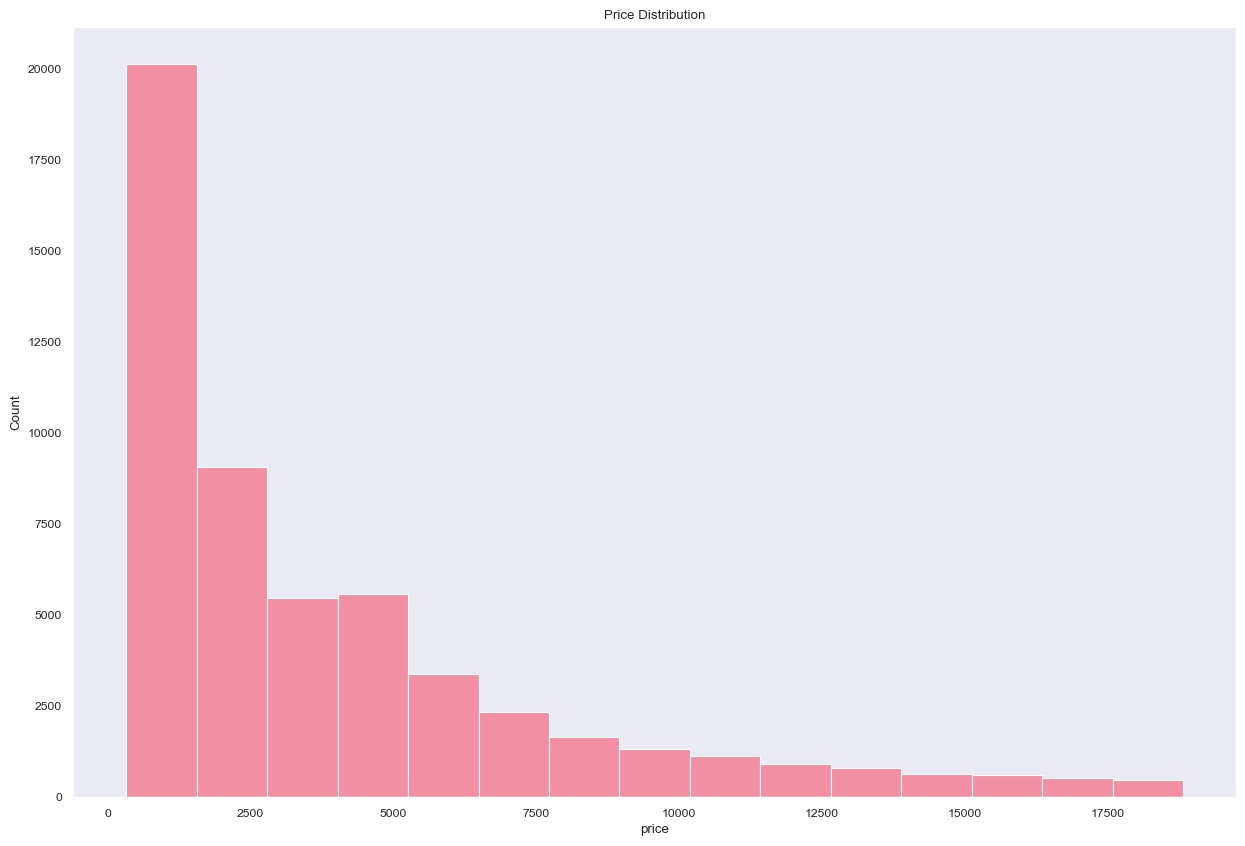

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(data = dataset, x = 'price', bins = 15)
plt.title('Price Distribution')
plt.show()

### Distribution of Categorical Features

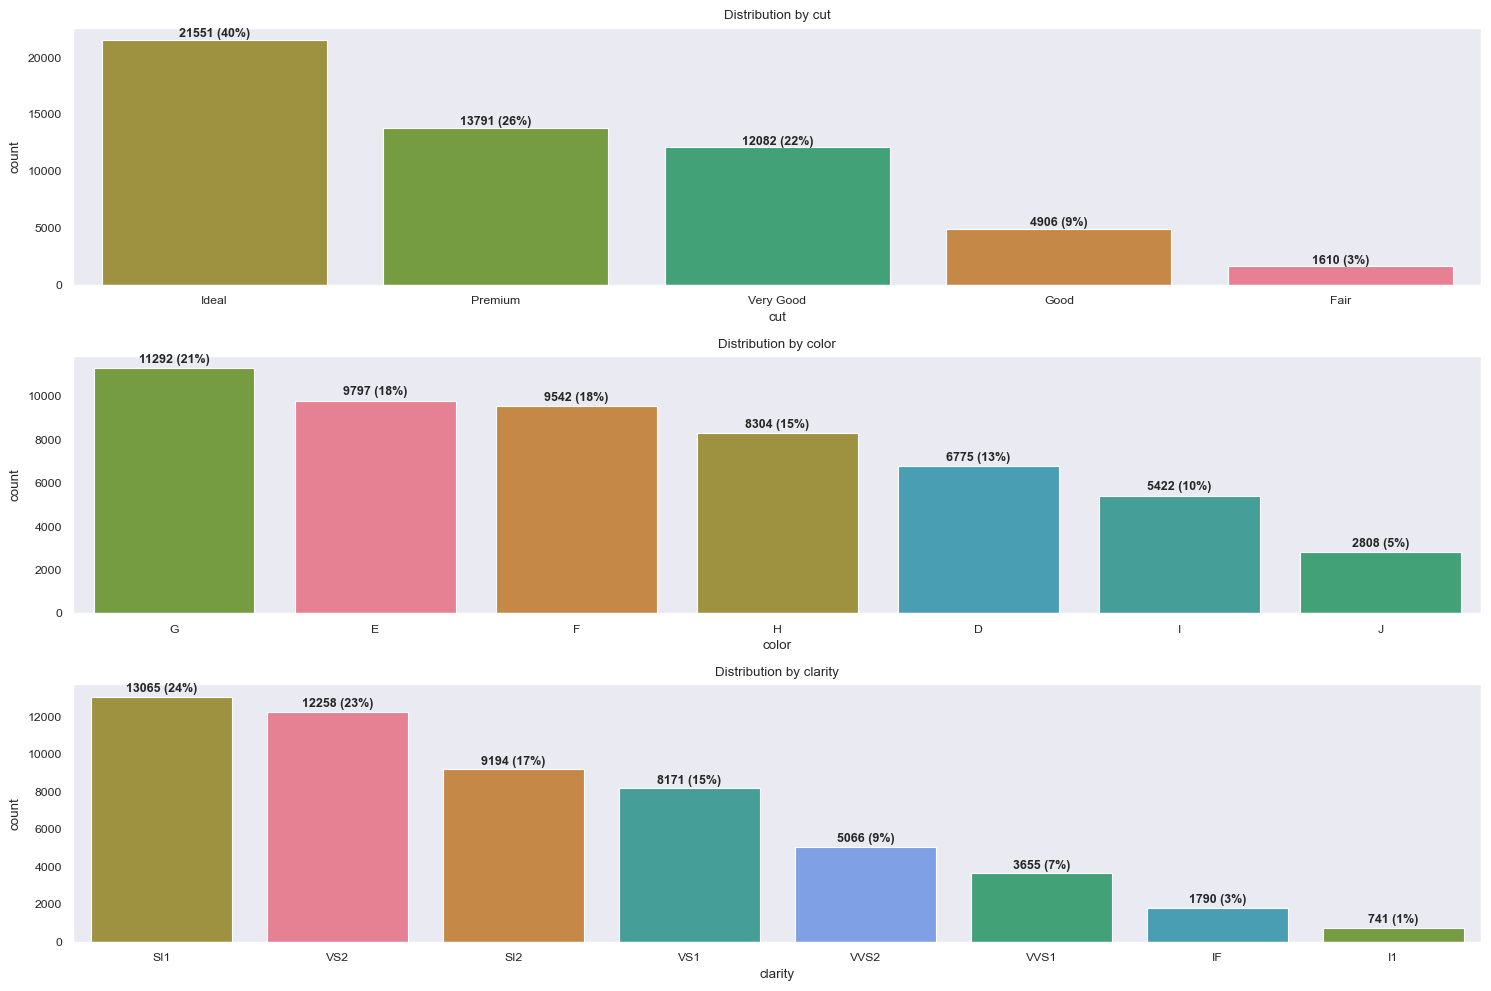

In [13]:
plt.figure(figsize=(15,10))

for index, feature in enumerate(categorical_features):
    abs_values = dataset[feature].value_counts(ascending=False)
    rel_values = dataset[feature].value_counts(ascending=False, normalize=True).values * 100
    lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]


    plt.subplot(3, 1, index + 1)
    ax = sns.countplot(data = dataset, 
                    x = feature, 
                    order=abs_values.index,
                    hue = feature, 
                    )

    # Extract bars in sorted order
    bars = sorted(ax.patches, key=lambda bar: bar.get_x())  # Sort bars by x-position

    # Annotate each bar with corresponding label
    for bar, lbl in zip(bars, lbls):  
        ax.text(bar.get_x() + bar.get_width()/2,  # X-coordinate (center of bar)
                bar.get_height() + 250,            # Y-coordinate (above bar)
                lbl,                              # Label text
                ha='center',                      # Center alignment
                fontsize=9, 
                fontweight='bold')
    
    plt.title('Distribution by ' + feature)
plt.tight_layout()
plt.show()

### Distribution of Numerical Features

In [14]:
dataset.describe()

carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  z             y  
count  53940.000000  53940.000000  
mean       3.538734      5.734526  
std        0.705699      1.142135  
min        0.000000      0.000000  
25%        2.910000      4.720000  
50%        3.530000      5.710000  
75%        4.040000      6.540000  
max       31.800000     58.900000

### Bivariate Analysis

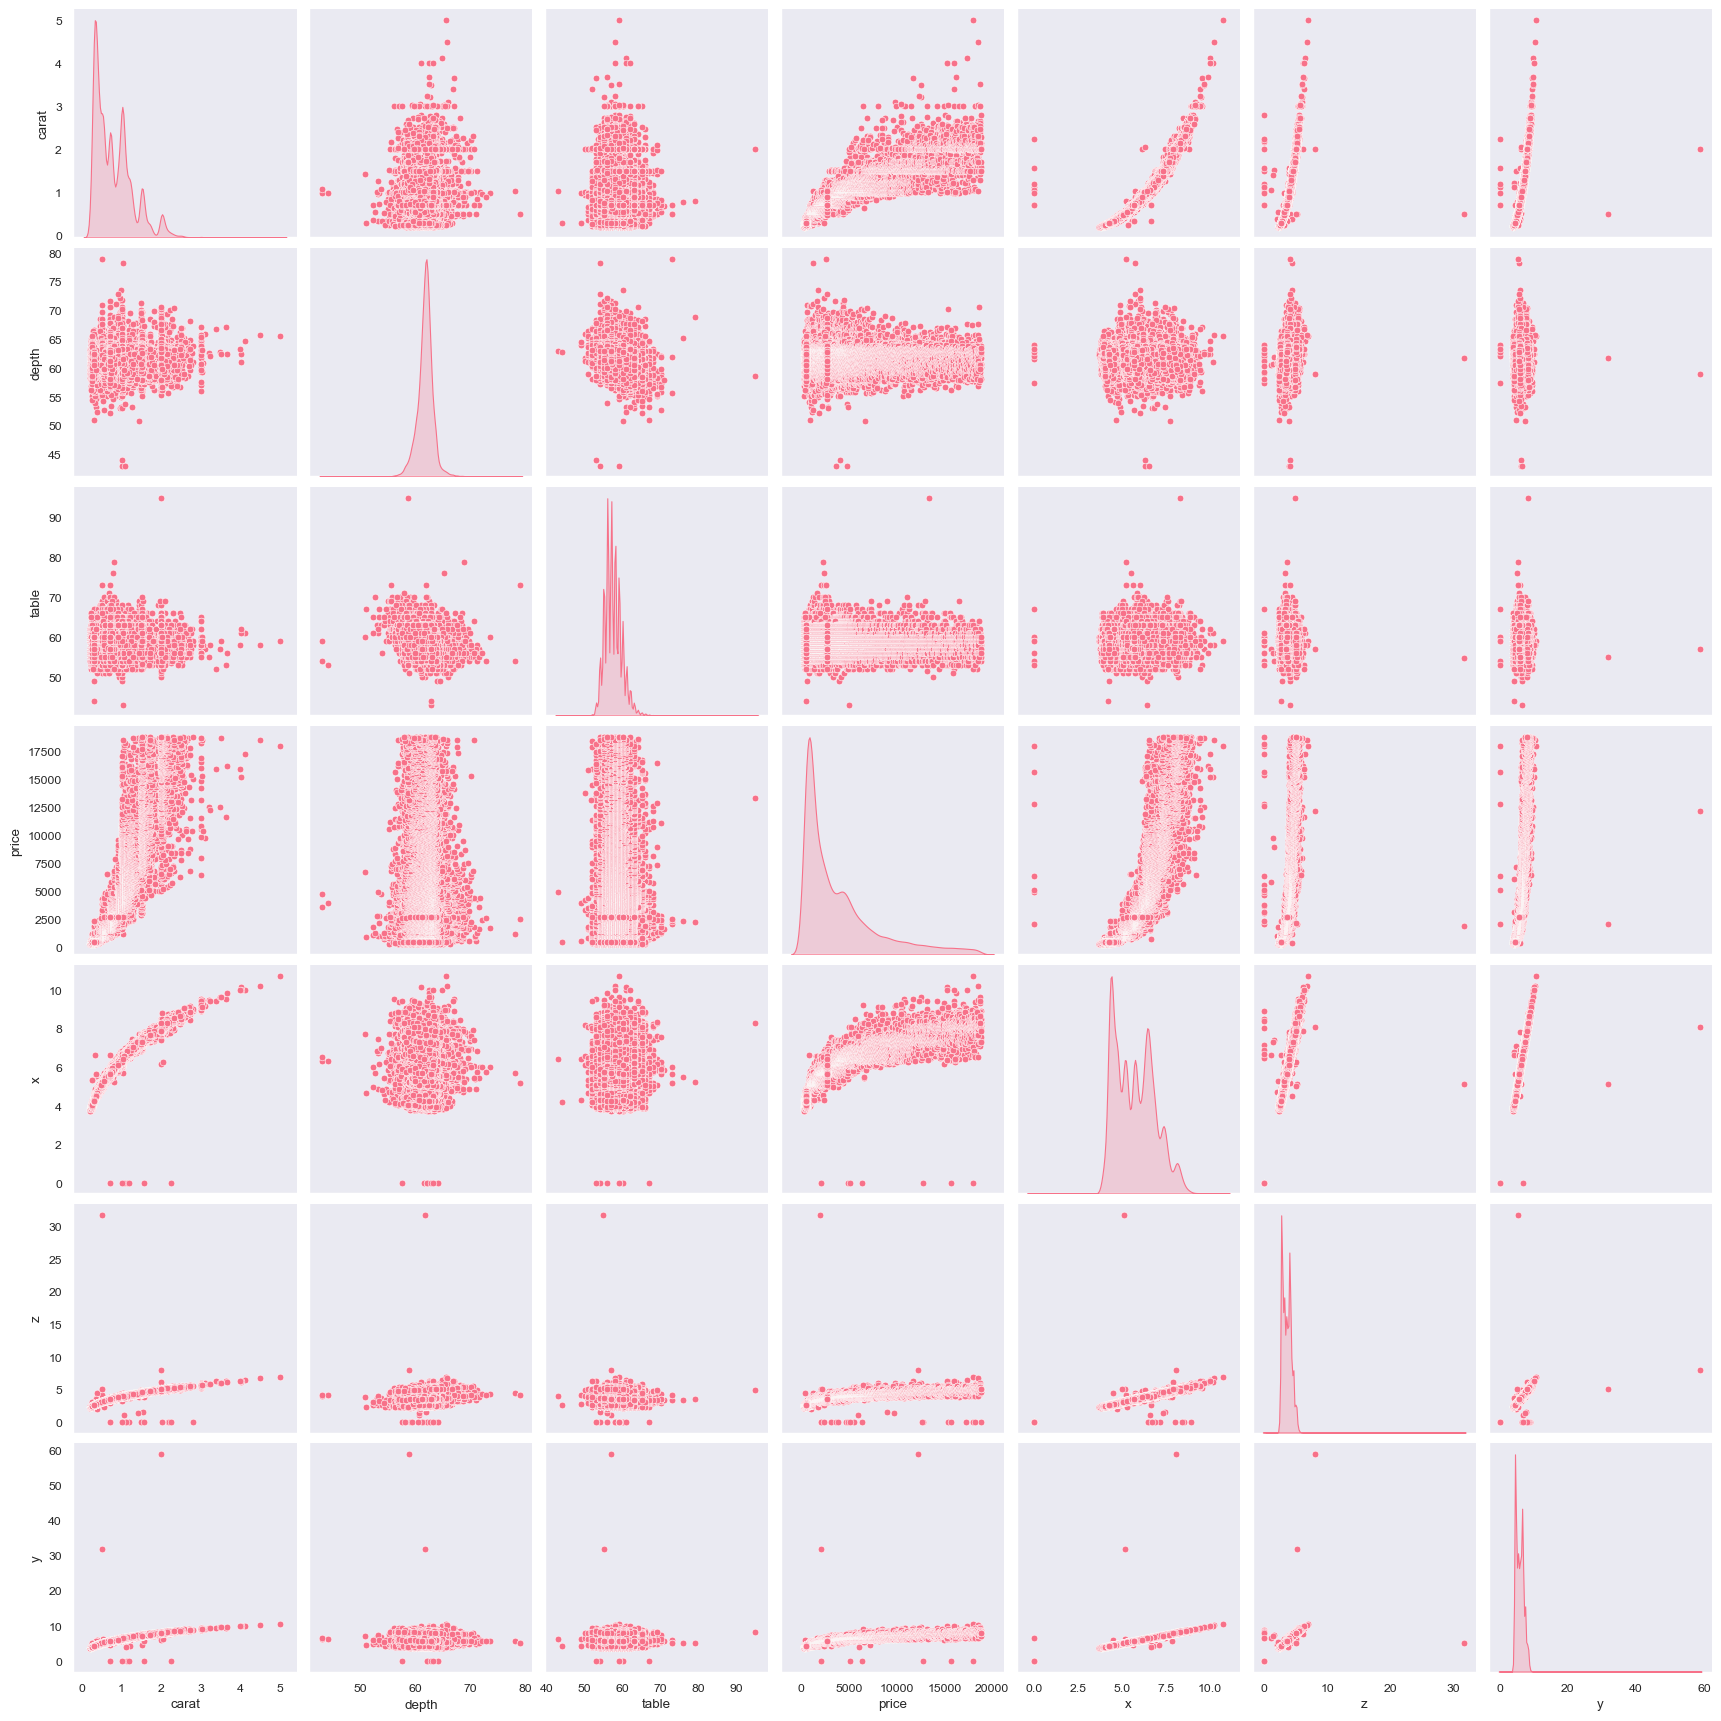

In [15]:
sns.pairplot(dataset[numerical_features], diag_kind='kde')
plt.show()

In [16]:
large_diamond = dataset['carat'].gt(dataset['carat'].quantile(0.75)).rename('large_diamond')

### **Cut - Best to Worst**
**Ideal -> Premium -> Very Good -> Good -> Fair**

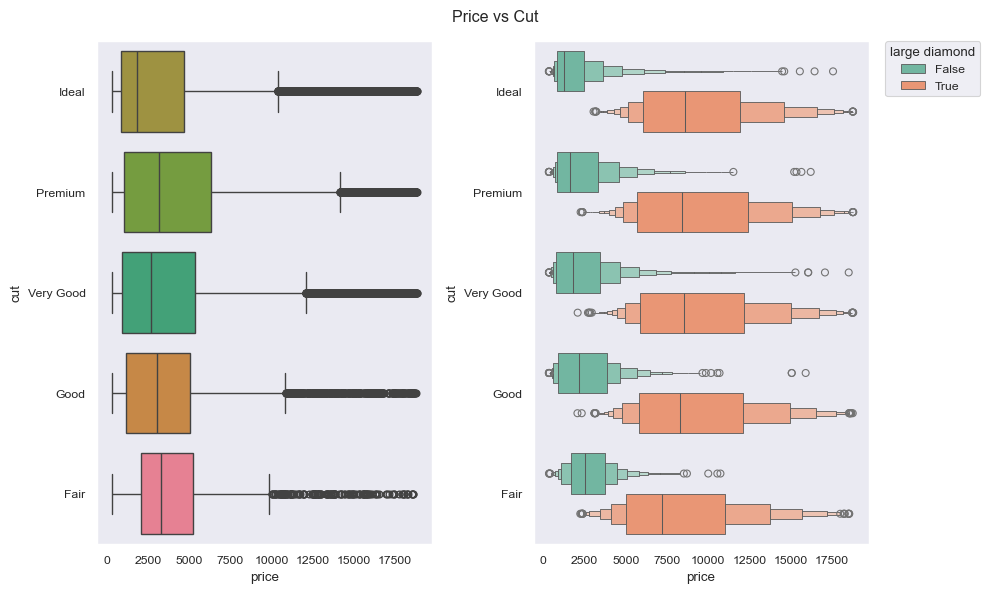

In [17]:
cut_order = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(data = dataset, x = 'price', y = 'cut', order = cut_order, hue = 'cut')

plt.subplot(1,2,2)
sns.boxenplot(data=dataset, x='price', y='cut', order = cut_order, legend='auto', hue = large_diamond, palette = 'Set2')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., title = 'large diamond')

plt.suptitle('Price vs Cut')
plt.tight_layout()
plt.show()

**Key Observations**
*   Higher cut quality does not always mean a higher price
*   Larger diamonds with any cut grade are more expensive than smaller, higher-quality diamonds

### **Clarity - Best to Worst**
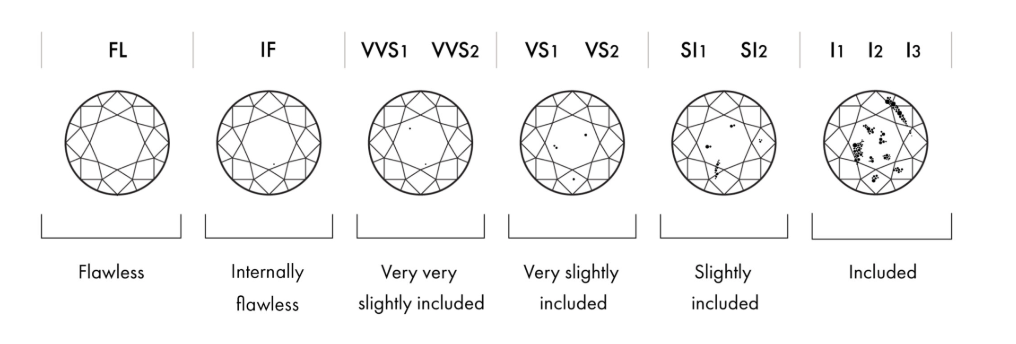

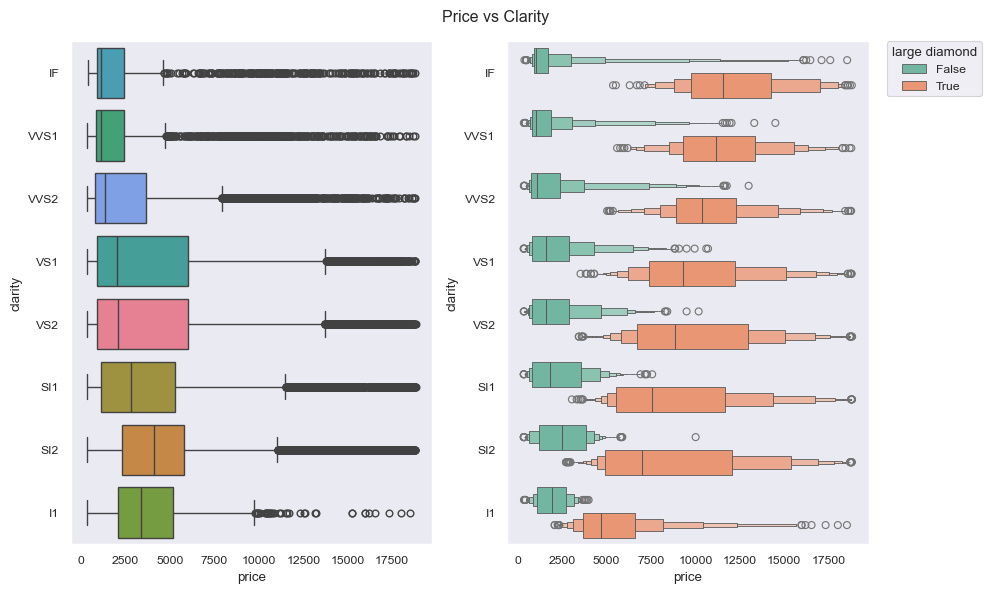

In [18]:
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(data=dataset, x='price', y='clarity', order = clarity_order, hue = 'clarity')

plt.subplot(1,2,2)
sns.boxenplot(data=dataset, x='price', y='clarity', order = clarity_order, legend='auto', hue = large_diamond, palette = 'Set2')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., title = 'large diamond')

plt.suptitle('Price vs Clarity')
plt.tight_layout()
plt.show()

**Key Observations**
*   Clarity impacts price but is not the strongest factor
*   Large diamonds with lower clarity can still be more expensive than small, high-clarity diamonds

### **Color - Best to Worst**
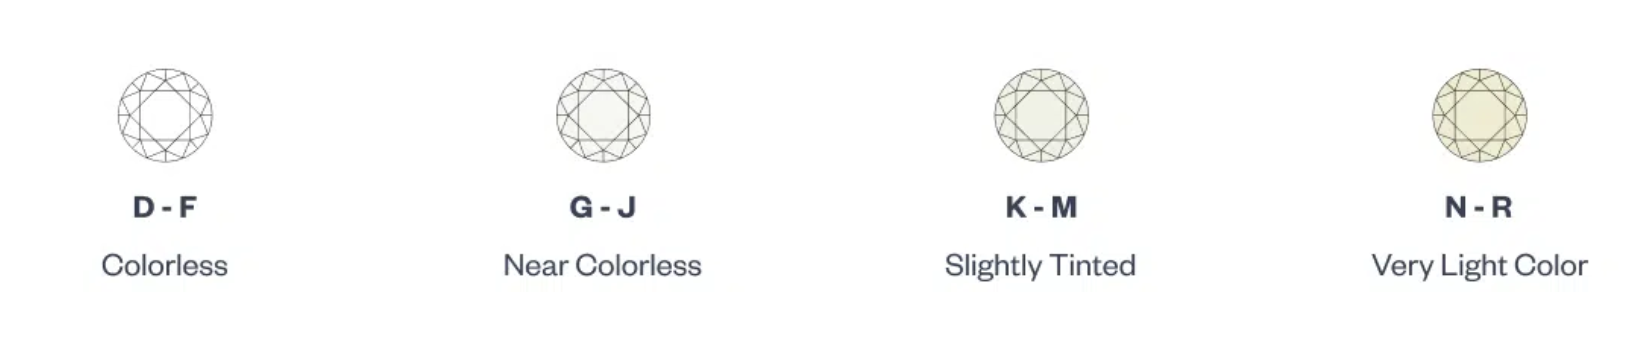

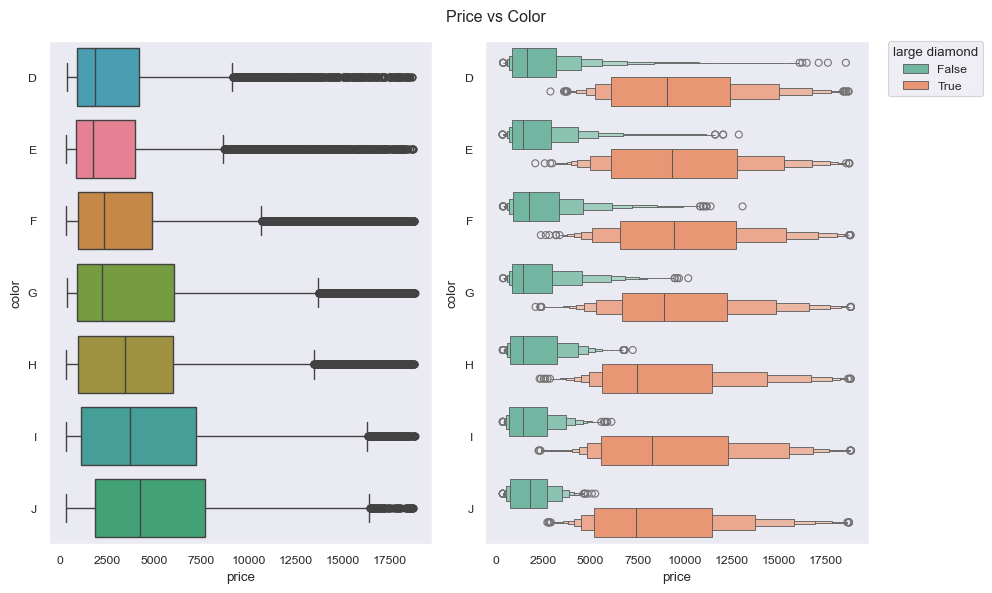

In [19]:
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(data=dataset, x='price', y='color', order = color_order, hue = 'color')

plt.subplot(1,2,2)
sns.boxenplot(data=dataset, x='price', y='color', order = color_order, legend='auto', hue = large_diamond, palette = 'Set2')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., title = 'large diamond')

plt.suptitle('Price vs Color')
plt.tight_layout()
plt.show()

**Key Observations**
*   Color alone does not determine price
*   Large diamonds significantly drive up prices across all color grades.

### Visualization of Price against all numerical features wrt Categorical Features and OLS Trendline

In [20]:
y_variables = ['price']
x_variables = numerical_features.tolist()
x_variables.remove('price')
col_variables = categorical_features
scope_values = ['overall', 'trace']


In [21]:
dataset

cut color clarity  carat  depth  table  price     x     z     y
0           Fair     E     VS2   0.22   65.1   61.0    337  3.87  2.49  3.78
1           Fair     E     SI2   0.86   55.1   69.0   2757  6.45  3.52  6.33
2           Fair     F     SI2   0.96   66.3   62.0   2759  6.27  4.07  5.95
3           Fair     F     VS2   0.70   64.5   57.0   2762  5.57  3.58  5.53
4           Fair     F     VS2   0.70   65.3   55.0   2762  5.63  3.66  5.58
...          ...   ...     ...    ...    ...    ...    ...   ...   ...   ...
53935  Very Good     E     VS2   0.70   62.8   60.0   2755  5.59  3.53  5.65
53936  Very Good     D     VS1   0.70   63.1   59.0   2755  5.67  3.55  5.58
53937  Very Good     E     VS2   0.70   60.5   59.0   2757  5.71  3.47  5.76
53938  Very Good     E     VS2   0.70   61.2   59.0   2757  5.69  3.49  5.72
53939  Very Good     D     SI1   0.70   62.8   60.0   2757  5.66  3.56  5.68

[53940 rows x 10 columns]

In [22]:
df = dataset.copy(deep=True)

In [23]:
# Plotly Visualization for dynamic graph

app = Dash(__name__, external_stylesheets=[dbc.themes.CERULEAN])

app.layout = dbc.Container(
    [
        dbc.Row(
            [
                dbc.Col(
                    [
                        dcc.Markdown(
                            "#### Plotly Express line chart with trendlines and dropdown",
                            className="text-white",

                        )
                    ],  # style={"textalign": "center"},
                    width=8
                )
            ],
            className="bg-secondary rounded-3 mt-2",
            # style={"textalign": "center"},

            justify="center"

        ),
        dbc.Row(

            [

                dbc.Col([dbc.Label(
                            "Target variable:",
                            # className="bg-info bg-opacity-50 mt-2 p-2",
                            className="mt-2 p-2",
                            style={"width": "100%"},
                        ),
                            dcc.Dropdown(y_variables,
                                        y_variables[0], id='y_val'),
                            dbc.Label(
                                "Explanatory variable:",
                                # className="bg-info bg-opacity-50 mt-2 p-2",
                                className="mt-2 p-2",
                                style={"width": "100%"},
                            ),
                            dcc.Dropdown(x_variables,
                                        x_variables[0], id='x_val'),
                            dbc.Label(
                                "Distribution variable:",
                                # className="bg-info bg-opacity-50 mt-2 p-2",
                                className="mt-2 p-2",
                                style={"width": "100%"},
                            ),
                            dcc.Dropdown(col_variables,
                                        col_variables[0], id='col_val'),
                            dbc.Label(
                                "Trendline Scope:",
                                # className="bg-info bg-opacity-50 mt-2 p-2",
                                className="mt-2 p-2",
                                style={"width": "100%"},
                            ),
                            dcc.Dropdown(scope_values,
                                        scope_values[0], id='scope_val'),

                    ], 
                        width=4
                ),
                dbc.Col(
                    [

                        dcc.Graph(id='fig1')
                    ]
                )
            ],
            className="bg-secondary bg-opacity-25 rounded-3 p-2 mt-2",
        ),
    ]
)


@ app.callback(Output('fig1', 'figure'),
               [Input('y_val', 'value'),
                Input('x_val', 'value'),
                Input('col_val', 'value'),
                Input('scope_val', 'value'),
                ])
def trends(y, x, col, scope):

    fig = px.scatter(df, x=x, y=y, color=col, trendline="ols", trendline_scope=scope)
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)')
    return fig

app.run(debug=True, use_reloader=False, mode='inline')

### Ordinal Encoding

Since using Random Forest, XGBoost ‚Üí Label Encoding is better. \
If using Linear Regression, SVM ‚Üí One-Hot Encoding is better. \
However, since we have order in the categories, manually defining mapping to set correct order.

In [24]:
#Using OrdinalEncoding to convert 
categories_order = [cut_order, color_order, clarity_order]

oe = OrdinalEncoder(categories = categories_order)
df_transformed = oe.fit_transform(dataset[categorical_features])
dataset[categorical_features] = df_transformed   

In [25]:
dataset

cut  color  clarity  carat  depth  table  price     x     z     y
0      4.0    1.0      4.0   0.22   65.1   61.0    337  3.87  2.49  3.78
1      4.0    1.0      6.0   0.86   55.1   69.0   2757  6.45  3.52  6.33
2      4.0    2.0      6.0   0.96   66.3   62.0   2759  6.27  4.07  5.95
3      4.0    2.0      4.0   0.70   64.5   57.0   2762  5.57  3.58  5.53
4      4.0    2.0      4.0   0.70   65.3   55.0   2762  5.63  3.66  5.58
...    ...    ...      ...    ...    ...    ...    ...   ...   ...   ...
53935  2.0    1.0      4.0   0.70   62.8   60.0   2755  5.59  3.53  5.65
53936  2.0    0.0      3.0   0.70   63.1   59.0   2755  5.67  3.55  5.58
53937  2.0    1.0      4.0   0.70   60.5   59.0   2757  5.71  3.47  5.76
53938  2.0    1.0      4.0   0.70   61.2   59.0   2757  5.69  3.49  5.72
53939  2.0    0.0      5.0   0.70   62.8   60.0   2757  5.66  3.56  5.68

[53940 rows x 10 columns]

Text(0.5, 1.0, 'Feature Correlation Heatmap')

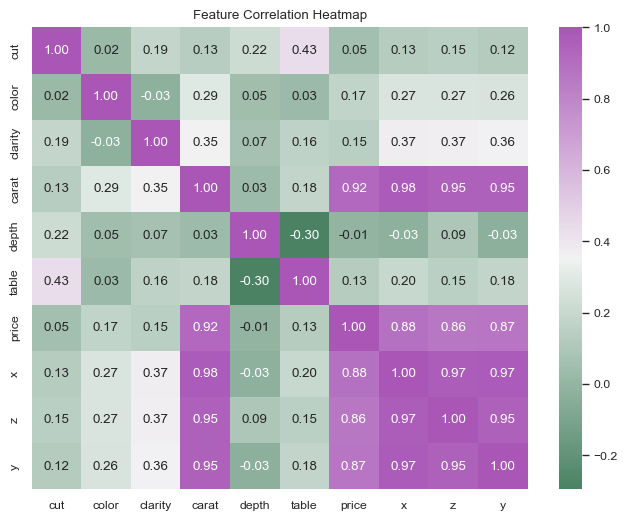

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(dataset.corr(), annot=True, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
, fmt='.2f')
plt.title('Feature Correlation Heatmap')

**Key Observations**
*   Carat is the most important factor in determining diamond price
*   Physical size (x, y, z) has a strong influence on price
*   Cut, color, and clarity play a much smaller role in price variation
*   Depth and table have little to no impact on price

### Outliers

In [27]:
outliers = pd.DataFrame()

for feature in numerical_features:
    Q1 = dataset[feature].quantile(0.25)
    Q3 = dataset[feature].quantile(0.75)


    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (dataset[feature] < lower_bound) | (dataset[feature] > upper_bound)
    outliers = pd.concat([outliers, dataset[feature][mask]], axis = 1)

In [28]:
outliers.head()

carat  depth  table  price   x   z   y
604   2.14   69.4    NaN    NaN NaN NaN NaN
606   2.15   65.5    NaN    NaN NaN NaN NaN
625   2.22   66.7    NaN    NaN NaN NaN NaN
637   2.01   67.4    NaN    NaN NaN NaN NaN
638   2.01   55.9   64.0    NaN NaN NaN NaN

In [29]:
print("Percentage of outliers")
print("----------------------")
outliers.count() / len(dataset) * 100

Percentage of outliers
----------------------


carat    3.502039
depth    4.718205
table    1.121617
price    6.562848
x        0.059325
z        0.090842
y        0.053763
dtype: float64

**Outliers have been retained for now. \
Their removal will be considered based on model selection and performance evaluation.**

## Feature Engineering

In [30]:
X = dataset.drop('price', axis = 1)
y = dataset['price']

### **Correlation and Mutual Information**

In [31]:

# Compute Pearson Correlation
correlation = X.corrwith(y)

# Compute Mutual Information
mi_scores = mutual_info_regression(X, y)

# Combine into DataFrame
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Correlation': correlation.values,
    'Mutual_Information': mi_scores
})

# Rank by importance (absolute correlation + MI)
feature_scores['Rank'] = feature_scores['Correlation'].abs() + feature_scores['Mutual_Information']
feature_scores = feature_scores.sort_values(by='Rank', ascending=False)

In [32]:
feature_scores

Feature  Correlation  Mutual_Information      Rank
3    carat     0.921591            1.961963  2.883554
6        x     0.884435            1.480716  2.365151
8        y     0.865421            1.492484  2.357905
7        z     0.861249            1.432047  2.293296
2  clarity     0.146800            0.362616  0.509416
1    color     0.172511            0.284247  0.456757
5    table     0.127134            0.053008  0.180142
0      cut     0.053491            0.102638  0.156128
4    depth    -0.010647            0.036231  0.046879

/var/folders/s9/jq10pq213hvgwhd8sxxh3lsc0000gn/T/ipykernel_52565/613925865.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




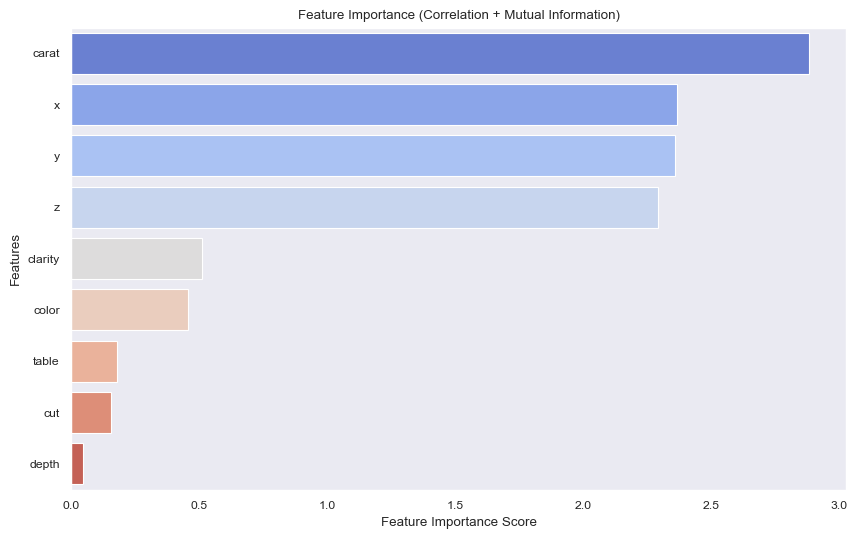

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_scores, x='Rank', y='Feature', palette='coolwarm')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance (Correlation + Mutual Information)')
plt.show()

## Model Development



### Iteration 1: Default Hyperparameters / All Features

In [34]:
X

cut  color  clarity  carat  depth  table     x     z     y
0      4.0    1.0      4.0   0.22   65.1   61.0  3.87  2.49  3.78
1      4.0    1.0      6.0   0.86   55.1   69.0  6.45  3.52  6.33
2      4.0    2.0      6.0   0.96   66.3   62.0  6.27  4.07  5.95
3      4.0    2.0      4.0   0.70   64.5   57.0  5.57  3.58  5.53
4      4.0    2.0      4.0   0.70   65.3   55.0  5.63  3.66  5.58
...    ...    ...      ...    ...    ...    ...   ...   ...   ...
53935  2.0    1.0      4.0   0.70   62.8   60.0  5.59  3.53  5.65
53936  2.0    0.0      3.0   0.70   63.1   59.0  5.67  3.55  5.58
53937  2.0    1.0      4.0   0.70   60.5   59.0  5.71  3.47  5.76
53938  2.0    1.0      4.0   0.70   61.2   59.0  5.69  3.49  5.72
53939  2.0    0.0      5.0   0.70   62.8   60.0  5.66  3.56  5.68

[53940 rows x 9 columns]

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators = 10, random_state = 0) # with default parameters


In [36]:
from xgboost import XGBRFRegressor
xgbrf_regressor = XGBRFRegressor(random_state=0) # with default parameters

In [37]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)

In [38]:
models = {'RandomForestRegressor': rf_regressor,
           'XGBRFRegressor': xgbrf_regressor,
           'KNeighborsRegressor': knn_regressor
           
         }

**Note**: Need to Scale the values since we are going to use KNN Regression model as well. \
Scaling not required for RandomForest and XGBoost

In [39]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cv_results = pd.DataFrame()
model_feature_imp = pd.DataFrame()

def train_models(models, X, y, cv_results, model_feature_imp, iter):

    for index, (key, value) in enumerate(models.items()):

        # Define Pipeline: Scaling + Model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Scale features within each CV fold
            ('model', value)
        ])

        result = cross_validate(pipeline, X, y, 
                                    cv=kf, 
                                    scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
                                    return_train_score = True,
                                    return_estimator = True)
        # print(result)
        # print("Important Features:", result['estimator'][0].feature_importances_)
        # print("Important Features:", type(result['estimator'][0].feature_importances_))
        # print("Model parameters:", result['estimator'][0].get_params())

        cross_val_result = pd.DataFrame(result)
        cross_val_result['Model'] = key 
        cross_val_result['r2_diff'] = cross_val_result['train_r2'] - cross_val_result['test_r2']
        cross_val_result['rmse_diff'] = cross_val_result['train_neg_root_mean_squared_error'] - cross_val_result['test_neg_root_mean_squared_error']
        cross_val_result['mae_diff'] = cross_val_result['train_neg_mean_absolute_error'] - cross_val_result['test_neg_mean_absolute_error']
        cross_val_result['iter'] = iter
        cross_val_result.drop('estimator', axis = 1, inplace=True)

        cv_results = pd.concat([cv_results, cross_val_result])

        model_result = result['estimator'][0].named_steps['model']
        # Check if the model has 'feature_importances_' attribute before accessing it
        if hasattr(model_result, "feature_importances_"):
            feature_imp_list = model_result.feature_importances_
            feature_imp_df = pd.DataFrame([feature_imp_list], columns = X.columns)
            feature_imp_df['Model'] = key 
            model_feature_imp = pd.concat([model_feature_imp, feature_imp_df])
        else:
            print(f"‚ö†Ô∏è The model {value} does not have feature_importances_ (e.g., KNN, SVM, etc.)")

    return cv_results, model_feature_imp
    


    

In [40]:
# iteration = 1 # First iteration with default model hyperparameters and all features
cv_results, model_feature_imp = train_models(models, X, y, cv_results, model_feature_imp, iter = 1)

‚ö†Ô∏è The model KNeighborsRegressor() does not have feature_importances_ (e.g., KNN, SVM, etc.)


**Feature Importance by Model**

In [41]:
model_feature_imp

cut     color   clarity     carat     depth     table         x  \
0  0.001795  0.031615  0.062438  0.539449  0.003179  0.002306  0.004563   
0  0.001562  0.013846  0.026741  0.525089  0.001481  0.001282  0.056215   

          z         y                  Model  
0  0.004569  0.350084  RandomForestRegressor  
0  0.004161  0.369624         XGBRFRegressor

#### Model Evaluation

In [42]:
cv_results


fit_time  score_time   test_r2  train_r2  test_neg_root_mean_squared_error  \
0  3.647157    0.033023  0.979442  0.996674                       -567.300075   
1  2.724287    0.030611  0.977980  0.996577                       -584.538478   
2  2.713056    0.033657  0.979243  0.996510                       -591.082969   
3  3.149764    0.049462  0.980925  0.996503                       -553.967642   
4  3.537446    0.027783  0.980171  0.996545                       -564.258893   
5  3.112092    0.032370  0.982159  0.996515                       -533.706819   
6  3.327341    0.032928  0.979180  0.996580                       -583.036932   
7  3.075645    0.028929  0.978646  0.996658                       -570.952864   
8  3.367135    0.051564  0.982249  0.996467                       -536.507524   
9  3.426102    0.046734  0.982160  0.996474                       -520.426153   
0  0.971584    0.020228  0.961030  0.962463                       -781.068481   
1  0.336892    0.011151  0.958524  0.963125                       -802.249329   
2  0.429533    0.012898  0.960123  0.962617                       -819.276367   
3  0.518279    0.012757  0.963029  0.962380                       -771.229980   
4  0.449846    0.012938  0.961295  0.962493                       -788.330872   
5  0.520189    0.013047  0.964797  0.962510                       -749.695862   
6  0.533093    0.013940  0.960965  0.962705                       -798.322754   
7  0.389018    0.011557  0.959601  0.962927                       -785.317200   
8  0.532865    0.012179  0.962201  0.962498                       -782.882568   
9  0.449137    0.012894  0.962086  0.962958                       -758.674683   
0  0.146394    0.671309  0.962792  0.979480                       -763.202956   
1  0.077872    0.634048  0.965264  0.979445                       -734.178874   
2  0.064835    0.312682  0.968943  0.979150                       -723.016038   
3  0.112827    0.393902  0.968131  0.979083                       -716.042051   
4  0.094205    0.289136  0.966607  0.979227                       -732.236641   
5  0.059503    0.254682  0.970999  0.979063                       -680.465009   
6  0.064597    0.238968  0.965202  0.979201                       -753.748726   
7  0.058882    0.266296  0.969781  0.979010                       -679.209399   
8  0.061269    0.237429  0.969786  0.979173                       -699.948349   
9  0.065443    0.267789  0.970859  0.978999                       -665.128621   

   train_neg_root_mean_squared_error  test_neg_mean_absolute_error  \
0                        -230.293219                   -280.870425   
1                        -233.718104                   -290.244368   
2                        -234.895253                   -288.644638   
3                        -235.762479                   -277.259531   
4                        -234.375859                   -282.620819   
5                        -235.465476                   -270.201846   
6                        -232.966325                   -284.035736   
7                        -231.128708                   -273.307934   
8                        -236.882194                   -272.808010   
9                        -237.473964                   -259.985014   
0                        -773.623535                   -435.810608   
1                        -767.139954                   -445.377350   
2                        -768.818909                   -460.083252   
3                        -773.300415                   -433.472382   
4                        -772.228210                   -440.745087   
5                        -772.306519                   -424.915558   
6                        -769.318909                   -445.568970   
7                        -769.835510                   -426.517975   
8                        -771.757385                   -439.402710   
9                        -769.746826                   -420.248230   
0                    

*   **R¬≤ (R-squared)**
    *   Measures how well the model explains the variance in the target variable.
    *   Ranges from 0 to 1 (or negative if the model is worse than a constant prediction).
    *   Best when you want an overall goodness-of-fit measure.
    *   *Limitation*: Doesn't directly show how much error the model makes in predicting prices.
*   **RMSE (Root Mean Squared Error)**
    *   Measures the average prediction error in original price units (USD in your case).
    *   Penalizes large errors more than small ones (because of squaring).
    *   Best when large price prediction errors are critical (e.g., for high-value diamonds).
    *   *Limitation*: Sensitive to outliers.
*   **MAE (Mean Absolute Error)**
    *   Measures the average absolute error in original price units (USD).
    *   Treats all errors equally (unlike RMSE).
    *   Best when you want a simple interpretation of average prediction error.
    *   *Limitation*: Doesn't penalize large errors as heavily as RMSE.

**Model Results from Cross Validation**

In [43]:
models_list = cv_results['Model'].unique().tolist()
len(models_list)

3

In [44]:
def plot_evaluation_metrics(models_list, cv_results, iter):
    fig, axes = plt.subplots(nrows = len(models_list), ncols = 3, figsize=(16, 8))
    for index, model in enumerate(models_list):

        #result = cv_results[cv_results['Model'] == model][cv_results['iter'] == iter]
        result = cv_results.query("Model == @model and iter == @iter")

        axes[index, 1].set_title(model, fontsize = 18)

        sns.lineplot(ax=axes[index, 0], data = result['train_r2'], label = 'Train: R2 Score')
        sns.lineplot(ax=axes[index, 0], data = result['test_r2'], label = 'Test: R2 Score')
        
        sns.lineplot(ax=axes[index, 1], data = result['train_neg_root_mean_squared_error'], label = 'Train: Negative RMSE ')
        sns.lineplot(ax=axes[index, 1], data = result['test_neg_root_mean_squared_error'], label = 'Test: Negative RMSE')

        sns.lineplot(ax=axes[index, 2], data = result['train_neg_mean_absolute_error'], label = 'Train: Negative MAE')
        sns.lineplot(ax=axes[index, 2], data = result['test_neg_mean_absolute_error'], label = 'Test: Negative MAE')
    plt.legend()
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

In [ ]:
plot_evaluation_metrics(models_list, cv_results, iter=1)

**Key Insights:**
*   **Overfitting in RandomForestRegressor**

    Train R¬≤ is nearly 1.0, while Test R¬≤ fluctuates lower. \
    This suggests overfitting, where the model performs exceptionally well on training data but struggles on unseen data. \
    RMSE and MAE differences also show a large gap, reinforcing the overfitting issue. \
*   **XGBRFRegressor Shows Better Stability**

    Test R¬≤ scores are more stable and closer to train R¬≤. \
    Less fluctuation in RMSE and MAE compared to RandomForestRegressor. \
    Better generalization ability across different iterations. \
*   **KNeighborsRegressor is the Most Erratic**

    Large variations in test R¬≤ across iterations. \
    Negative RMSE and MAE fluctuate significantly, indicating inconsistency in performance. \
    Possibly high sensitivity to hyperparameters or dataset variations. \

**Overall Conclusion:**
*   **XGBRFRegressor** appears to be the `most balanced model` with lower overfitting and more stable error metrics.
*   **RandomForestRegressor** shows `signs of overfitting`, performing much better on training data than on test data.
*   **KNeighborsRegressor** exhibits the `most instability`, requiring tuning or reconsideration for this dataset.

    To improve generalization, will work on:
*   **Hyperparameter Tuning** (e.g., reducing max depth, increasing regularization).
*   **Feature Engineering** to reduce noise

### Iteration 2: Hyperparameter Tuning / All Features

**Using Optuna**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [46]:
# initialize objectives
objectives = ["R2", "RMSE", "MAE"]

In [47]:
def eval_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return r2, rmse, mae

In [48]:
def plot_history(study):
    fig1 = optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[0], target_name = "R2")
    show(fig1)
    fig2 = optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[1], target_name = "RMSE")
    show(fig2)
    fig3 = optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[2], target_name = "MAE")
    show(fig3)

In [49]:
def plot_hyperparameter_importances(study):
    fig1 = optuna.visualization.plot_param_importances(study, target = lambda t: t.values[0], target_name = "MAE")
    show(fig1)
    fig2 = optuna.visualization.plot_param_importances(study, target = lambda t: t.values[1], target_name = "RMSE")
    show(fig2)
    fig3 = optuna.visualization.plot_param_importances(study, target = lambda t: t.values[2], target_name = "MAE")
    show(fig3)

In [50]:
def find_best_scores(study):
    print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

    trial_with_highest_r2_score = max(study.best_trials, key=lambda t: t.values[0])
    # print("Trial with highest R2_score: ")
    # print(f"\tnumber: {trial_with_highest_r2_score.number}")
    # print(f"\tparams: {trial_with_highest_r2_score.params}")
    # print(f"\tvalues: {trial_with_highest_r2_score.values}")

    trial_with_lowest_rmse = min(study.best_trials, key=lambda t: t.values[1])
    # print("Trial with lowest RMSE: ")
    # print(f"\tnumber: {trial_with_lowest_rmse.number}")
    # print(f"\tparams: {trial_with_lowest_rmse.params}")
    # print(f"\tvalues: {trial_with_lowest_rmse.values}")

    trial_with_lowest_mae = min(study.best_trials, key=lambda t: t.values[2])
    # print("Trial with lowest MAE: ")
    # print(f"\tnumber: {trial_with_lowest_mae.number}")
    # print(f"\tparams: {trial_with_lowest_mae.params}")
    # print(f"\tvalues: {trial_with_lowest_mae.values}")

    return trial_with_highest_r2_score, trial_with_lowest_rmse, trial_with_lowest_mae

In [51]:
# Create an empty DataFrame
best_hyperparam_scores = pd.DataFrame(columns=['Model', 'TrialNumber', 'R2', 'RMSE', 'MAE', 'Params'])

def save_best_hyperparams(model_name, best_hyperparam_scores, trial_with_highest_r2_score, trial_with_lowest_rmse, trial_with_lowest_mae):
    
    best_hyperparams_list = [
        [model_name, 
         trial_with_highest_r2_score.number, 
         trial_with_highest_r2_score.values[0], 
         trial_with_highest_r2_score.values[1], 
         trial_with_highest_r2_score.values[2], 
         trial_with_highest_r2_score.params],
        
        [model_name, 
         trial_with_lowest_rmse.number, 
         trial_with_lowest_rmse.values[0], 
         trial_with_lowest_rmse.values[1], 
         trial_with_lowest_rmse.values[2], 
         trial_with_lowest_rmse.params],
        
        [model_name, 
         trial_with_lowest_mae.number, 
         trial_with_lowest_mae.values[0], 
         trial_with_lowest_mae.values[1], 
         trial_with_lowest_mae.values[2], 
         trial_with_lowest_mae.params]
    ]

    # Convert list to DataFrame
    df_to_add = pd.DataFrame(best_hyperparams_list, columns=best_hyperparam_scores.columns)

    # Use pd.concat() to append rows correctly
    # Check if the DataFrame to add is empty before concatenation
    if not df_to_add.empty:
        best_hyperparam_scores = pd.concat([best_hyperparam_scores, df_to_add], ignore_index=True)
    

    return best_hyperparam_scores  # Return the updated DataFrame

#### Random Forest Algorithm

<font color = '#00008B'>**Note:** While cross_val_score works fine, multi-objective function keeps returning the same value for each trial. \
Since we want to evaluate our model on multple parameters like R2, RMSE and MAE, switching to use train, test split.

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf)
    
    #score = cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1).mean()

    #return score

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return eval_model(y_test, y_pred)
    
    

In [ ]:
# study = optuna.create_study(direction = 'maximize', 
#                             sampler = optuna.samplers.RandomSampler(seed = 42))
study_rf = optuna.create_study(directions = ['maximize', 'minimize', 'minimize'], 
                           sampler = optuna.samplers.RandomSampler(seed = 42))
study_rf.optimize(objective_rf, n_trials = 35)

In [ ]:
study_rf.best_trials

In [ ]:
trial_best_r2, trial_best_rmse, trial_best_mae = find_best_scores(study_rf)
best_hyperparam_scores = save_best_hyperparams("RandomForestRegressor", best_hyperparam_scores, trial_best_r2, trial_best_rmse, trial_best_mae)

best_hyperparam_scores

In [ ]:
optuna.visualization.plot_pareto_front(study_rf, target_names=objectives)

In [ ]:
plot_history(study_rf)

In [ ]:
plot_hyperparameter_importances(study_rf)

<font color="blue">Running study with 50 trials took 46 minutes identifying two sets as best parameters for achieving max R2 and min RMSE or MAE with max_depth being the most important hyper parameter.

#### XGBoost Algorithm

In [52]:
def objective_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_parallel_tree': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma':trial.suggest_float('gamma', 0.0, 0.4),
        'reg_lambda': trial.suggest_float("reg_lambda", 1, 20),
        'reg_alpha': trial.suggest_float("reg_alpha", 1, 20),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True)
    }

    model = XGBRFRegressor(**param)
    
    #score = cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1).mean()

    #return score

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return eval_model(y_test, y_pred)

In [53]:
study_xgb = optuna.create_study(directions = ['maximize', 'minimize', 'minimize'], 
                           sampler = optuna.samplers.RandomSampler(seed = 42))
study_xgb.optimize(objective_xgb, n_trials = 200)

[I 2025-03-25 05:48:52,845] A new study created in memory with name: no-name-a8b69aa3-df8d-4dd2-a83e-64cce21869ec
[I 2025-03-25 05:48:53,466] Trial 0 finished with values: [0.9468883275985718, 909.836669921875, 509.2395324707031] and parameters: {'max_depth': 5, 'n_estimators': 956, 'min_child_weight': 5, 'gamma': 0.23946339367881464, 'reg_lambda': 3.964354168406294, 'reg_alpha': 3.96389588638785, 'eta': 2.9152036385288193e-08}.
[I 2025-03-25 05:48:54,065] Trial 1 finished with values: [0.9548570513725281, 838.809814453125, 461.41162109375] and parameters: {'max_depth': 9, 'n_estimators': 641, 'min_child_weight': 5, 'gamma': 0.008233797718320978, 'reg_lambda': 19.428287191077892, 'reg_alpha': 16.816410175208013, 'eta': 4.997040685255803e-07}.
[I 2025-03-25 05:48:54,394] Trial 2 finished with values: [0.9233865141868591, 1092.7509765625, 614.1642456054688] and parameters: {'max_depth': 4, 'n_estimators': 265, 'min_child_weight': 2, 'gamma': 0.20990257265289514, 'reg_lambda': 9.206955354

In [54]:
study_xgb.best_trials

[FrozenTrial(number=171, state=1, values=[0.9733075499534607, 645.0048828125, 342.9036560058594], datetime_start=datetime.datetime(2025, 3, 25, 5, 50, 22, 579239), datetime_complete=datetime.datetime(2025, 3, 25, 5, 50, 23, 618763), params={'max_depth': 10, 'n_estimators': 775, 'min_child_weight': 1, 'gamma': 0.30330527837160903, 'reg_lambda': 1.4671514127172287, 'reg_alpha': 1.4203474790509478, 'eta': 3.880446973849826e-06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'min_child_weight': IntDistribution(high=6, log=False, low=1, step=1), 'gamma': FloatDistribution(high=0.4, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=20.0, log=False, low=1.0, step=None), 'reg_alpha': FloatDistribution(high=20.0, log=False, low=1.0, step=None), 'eta': FloatDistribution(high=1.0, log=True, low=1e-08, step=None)}, tria

In [55]:
plot_history(study_xgb)

In [56]:
plot_hyperparameter_importances(study_xgb)

<font color="blue">Running study with 200 trials took less than 3 minutes identifying only one set of best parameters for achieving max R2 and min RMSE or MAE with max_depth being the most important hyper parameter.

In [57]:
trial_best_r2, trial_best_rmse, trial_best_mae = find_best_scores(study_xgb)
best_hyperparam_scores = save_best_hyperparams("XGBRFRegressor", best_hyperparam_scores, trial_best_r2, trial_best_rmse, trial_best_mae)

best_hyperparam_scores

Number of trials on the Pareto front: 1


/var/folders/s9/jq10pq213hvgwhd8sxxh3lsc0000gn/T/ipykernel_52565/4257354991.py:35: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Model TrialNumber        R2        RMSE         MAE  \
0  XGBRFRegressor         171  0.973308  645.004883  342.903656   
1  XGBRFRegressor         171  0.973308  645.004883  342.903656   
2  XGBRFRegressor         171  0.973308  645.004883  342.903656   

                                              Params  
0  {'max_depth': 10, 'n_estimators': 775, 'min_ch...  
1  {'max_depth': 10, 'n_estimators': 775, 'min_ch...  
2  {'max_depth': 10, 'n_estimators': 775, 'min_ch...

#### KNN Algorithm

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
def objective_knn(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 25),
    }

    model = KNeighborsRegressor(**param)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return eval_model(y_test, y_pred)

In [ ]:
study_knn = optuna.create_study(directions = ['maximize', 'minimize', 'minimize'], 
                           sampler = optuna.samplers.BruteForceSampler(seed = 42))
study_knn.optimize(objective_knn, n_trials = 25)

In [ ]:
study_knn.best_trials

In [ ]:
plot_history(study_knn)

<font color="blue">Running study with 25 trials with BruteForceSampler since there is only one hyperparameter, it took less than a minute identifying only two sets of best parameters for achieving max R2 and min RMSE or MAE.

In [ ]:
trial_best_r2, trial_best_rmse, trial_best_mae = find_best_scores(study_knn)

best_hyperparam_scores = save_best_hyperparams("KNeighborsRegressor", best_hyperparam_scores, trial_best_r2, trial_best_rmse, trial_best_mae)

best_hyperparam_scores

In [ ]:
best_params_xgbrf = best_hyperparam_scores.loc[
    best_hyperparam_scores['Model'] == 'XGBRFRegressor', 'Params'
].drop_duplicates().iloc[0]

xgbrf_regressor = XGBRFRegressor(**best_params_xgbrf, random_state=0)

best_params_rf = best_hyperparam_scores.loc[
    best_hyperparam_scores['Model'] == 'RandomForestRegressor', 'Params'
].drop_duplicates().iloc[0]

rf_regressor = RandomForestRegressor(**best_params_rf, random_state=0)

best_params_knn = best_hyperparam_scores.loc[
    best_hyperparam_scores['Model'] == 'KNeighborsRegressor', 'Params'
].drop_duplicates().iloc[0]

knn_regressor = KNeighborsRegressor(**best_params_knn)



In [ ]:
# Rebuild the dictionary
models = {
    'RandomForestRegressor': rf_regressor,
    'XGBRFRegressor': xgbrf_regressor,
    'KNeighborsRegressor': knn_regressor
}

models

In [ ]:
# iteration = 2 # Second iteration with best hyperparameters and all features
cv_results, model_feature_imp = train_models(models, X, y, cv_results, model_feature_imp, iter = 2)

cv_results

In [ ]:
model_feature_imp

In [ ]:
plot_evaluation_metrics(models_list, cv_results, iter=2)

### Iteration 3: Best Hyperparameters / Top Features

In [ ]:
feature_scores

In [ ]:
top_features = feature_scores[feature_scores['Rank'] > 1]['Feature']
top_features

In [ ]:
dataset

In [ ]:
X = dataset[top_features.tolist()]
X

In [ ]:
# iteration = 3 # Third iteration with best hyperparameters and top features
cv_results, model_feature_imp = train_models(models, X, y, cv_results, model_feature_imp, iter = 3)
cv_results

In [ ]:
model_feature_imp

In [ ]:
plot_evaluation_metrics(models_list, cv_results, iter=3)

### Iteration 4: Best Hyperparameters / Custom Features

In [59]:
dataset['size'] = dataset['x'] * dataset['y'] * dataset['z']
dataset

cut  color  clarity  carat  depth  table  price     x     z     y  \
0      4.0    1.0      4.0   0.22   65.1   61.0    337  3.87  2.49  3.78   
1      4.0    1.0      6.0   0.86   55.1   69.0   2757  6.45  3.52  6.33   
2      4.0    2.0      6.0   0.96   66.3   62.0   2759  6.27  4.07  5.95   
3      4.0    2.0      4.0   0.70   64.5   57.0   2762  5.57  3.58  5.53   
4      4.0    2.0      4.0   0.70   65.3   55.0   2762  5.63  3.66  5.58   
...    ...    ...      ...    ...    ...    ...    ...   ...   ...   ...   
53935  2.0    1.0      4.0   0.70   62.8   60.0   2755  5.59  3.53  5.65   
53936  2.0    0.0      3.0   0.70   63.1   59.0   2755  5.67  3.55  5.58   
53937  2.0    1.0      4.0   0.70   60.5   59.0   2757  5.71  3.47  5.76   
53938  2.0    1.0      4.0   0.70   61.2   59.0   2757  5.69  3.49  5.72   
53939  2.0    0.0      5.0   0.70   62.8   60.0   2757  5.66  3.56  5.68   

             size  
0       36.425214  
1      143.716320  
2      151.837455  
3      110.271518  
4      114.980364  
...           ...  
53935  111.489755  
53936  112.317030  
53937  114.126912  
53938  113.588332  
53939  114.449728  

[53940 rows x 11 columns]

In [ ]:
X = dataset[['carat', 'size']]
X

In [ ]:
# iteration = 4 # Fourth iteration with best hyperparameters and selected features
cv_results, model_feature_imp = train_models(models, X, y, cv_results, model_feature_imp, iter = 4)

In [ ]:
cv_results

In [ ]:
model_feature_imp

In [ ]:
plot_evaluation_metrics(models_list, cv_results, iter=4)

In [ ]:
desired_order = ['Model', 'iter', 
                 'r2_diff', 'rmse_diff', 'mae_diff', 
                 'test_r2', 'train_r2', 
                 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error', 
                 'test_neg_mean_absolute_error', 'train_neg_mean_absolute_error',
                 'fit_time', 'score_time']

In [ ]:
cv_results = cv_results[desired_order]

In [ ]:
summary_stats = cv_results.groupby(['Model', 'iter']).mean(numeric_only=True)
summary_stats

### Conclusion


**Key Metrics to Consider:**
*   **Best** `test_r2` (higher is better)

    *   **RandomForestRegressor (iter 2)**: 0.981741 (best fit to test data)
*   **Lowest** `RMSE` (test_neg_root_mean_squared_error, most negative is better)

    *   **RandomForestRegressor (iter 2)**: -538.3694 (lowest error)
*   **Lowest** `r2_diff` (closer to 0 means train and test scores are similar, indicating less overfitting)

    *   **XGBRFRegressor (iter 1)**: 0.001257 (most stable model)
*   **Lowest** `rmse_diff` (smallest train-test RMSE difference, means consistent predictions)

    *   **XGBRFRegressor (iter 1)**: 12.46 (most stable)
*   **Lowest** `mae_diff` (smallest train-test MAE difference, means stable absolute error across sets)

    *   **XGBRFRegressor (iter 1)**: 4.99 (most stable)


**Best Model Choice:**
*   **Overall Best Model: üèÜ RandomForestRegressor (iter 2)**

    `Highest test_r2` and `lowest RMSE`.\
    Best fit for predictions with lower error.
*   **Most Stable Model (if avoiding overfitting matters): XGBRFRegressor (iter 1)**

    `Smallest r2_diff`, `rmse_diff`, and `mae_diff`.\
    If prediction consistency matters more than absolute accuracy, this could be an alternative.

<font color="blue">Opting to go with XGBRFRegressor from iteration 2 with best hyperparameters, slightly higher R2 score and lower RMSE. Difference in R2 scores is not lowest, but it is still low enough to give us an increase of ~1% in accuracy

## Final Model

### Build Model

In [60]:
X = dataset.drop(['price', 'size'], axis = 1)
y = dataset['price']
# Performing split again with different random_state value
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

In [98]:
X

cut  color  clarity  carat  depth  table     x     z     y
0      4.0    1.0      4.0   0.22   65.1   61.0  3.87  2.49  3.78
1      4.0    1.0      6.0   0.86   55.1   69.0  6.45  3.52  6.33
2      4.0    2.0      6.0   0.96   66.3   62.0  6.27  4.07  5.95
3      4.0    2.0      4.0   0.70   64.5   57.0  5.57  3.58  5.53
4      4.0    2.0      4.0   0.70   65.3   55.0  5.63  3.66  5.58
...    ...    ...      ...    ...    ...    ...   ...   ...   ...
53935  2.0    1.0      4.0   0.70   62.8   60.0  5.59  3.53  5.65
53936  2.0    0.0      3.0   0.70   63.1   59.0  5.67  3.55  5.58
53937  2.0    1.0      4.0   0.70   60.5   59.0  5.71  3.47  5.76
53938  2.0    1.0      4.0   0.70   61.2   59.0  5.69  3.49  5.72
53939  2.0    0.0      5.0   0.70   62.8   60.0  5.66  3.56  5.68

[53940 rows x 9 columns]

In [63]:
final_model = XGBRFRegressor(**best_params_xgbrf, random_state = 0)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

r2_coeff, rmse, mae = eval_model(y_test, y_pred)

print(f"R2 Score: {r2_coeff}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R2 Score: 0.974605143070221
RMSE: 628.1008911132812
MAE: 335.35589599609375


### Save Model

In [ ]:
joblib.dump(final_model, filename = "model/PricePredictor.pkl")
joblib.dump(oe, filename = "model/OrdEncoder.pkl")

['model/OrdEncoder.pkl']

In [68]:
model = joblib.load('model/PricePredictor.pkl')
oe_new = joblib.load('model/OrdEncoder.pkl')


In [95]:
input_data = df.iloc[3638]
input_dict = input_data.to_dict()
input_dict

{'cut': 'Good',
 'color': 'D',
 'clarity': 'SI2',
 'carat': 0.32,
 'depth': 63.9,
 'table': 58.0,
 'price': 612,
 'x': 4.33,
 'z': 2.76,
 'y': 4.31}

In [103]:
raw_data = np.array([
            input_dict["cut"],
            input_dict["color"],
            input_dict["clarity"],
            input_dict["carat"],
            input_dict["depth"],
            input_dict["table"],
            input_dict["x"],
            input_dict["z"],
            input_dict["y"]
        ]).reshape(1, -1)
raw_data

array([['Good', 'D', 'SI2', '0.32', '63.9', '58.0', '4.33', '2.76',
        '4.31']], dtype='<U32')

In [104]:
encoded_data = oe_new.transform(raw_data[:, 0:3])
raw_data[:, 0:3] = encoded_data
raw_data

/opt/anaconda3/envs/SDSenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OrdinalEncoder was fitted with feature names



array([['3.0', '0.0', '6.0', '0.32', '63.9', '58.0', '4.33', '2.76',
        '4.31']], dtype='<U32')

In [105]:
# Convert entire array to float for XGBoost compatibility
raw_data = raw_data.astype(float)


In [106]:
prediction = model.predict(raw_data)
prediction

array([628.4367], dtype=float32)

In [84]:
y_pred = model.predict(X_test)
df_results = pd.DataFrame({
    'Predicted': y_pred,  # Ensure it's a 1D array
    'Actual': y_test
})

df_results

Predicted  Actual
10176   4635.495605    5057
16083    599.801086     670
13420   7993.965332    9326
20407   1223.942993     958
8909    4126.771973    4175
...             ...     ...
42208   2908.437256    2990
3638     628.436707     612
5508    1336.104492    1385
19535    892.887390     895
47950  13901.069336   13732

[10788 rows x 2 columns]